# Imports and settings

In [1]:
### Do the imports -- no need to change this
import numpy as np
from typing import List
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import sys

In [37]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
torch.manual_seed(0)

import csv

import base64, io

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
from utils.classes import Policy

import utils.classes
torch.serialization.add_safe_globals([getattr, torch.nn.modules.linear.Linear, utils.classes.Policy])

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


'\nclass Policy(nn.Module): #\xa0define the policy network\n    def __init__(self, state_size=4, action_size=2, hidden_size=32):\n        super(Policy, self).__init__()\n        self.fc1 = nn.Linear(state_size, hidden_size)\n        self.fc2 = nn.Linear(hidden_size, action_size)\n\n    def forward(self, state):\n        x = F.relu(self.fc1(state))\n        x = self.fc2(x)\n        return F.softmax(x, dim=1) # we just consider 1 dimensional probability of action\n\n    def act(self, state):\n        state = torch.from_numpy(state).float().unsqueeze(0).to(device)\n        probs = self.forward(state).cpu()\n        model = Categorical(probs)\n        action = model.sample()\n        return action.item(), model.log_prob(action)\n    \n    def get_prob(self, state, action):\n        state = torch.from_numpy(state).float().unsqueeze(0).to(device)\n        probs = self.forward(state).cpu()\n        return probs[0, action]\n'

In [14]:
SEEDS = [42, 123, 456]
TOTAL_TIMESTEPS = 50000
ENV_NAME = ['CartPole-v1', 'MountainCar-v0']
EVAL_N_EPISODES = 5
EVAL_LEARNING_RATE = 0.005

# DPO

In [ ]:
PATH = os.path.abspath(os.getcwd())
# path of pi1 and pi2 weights
pi1_path = os.path.join(PATH, 'saved_policies', 'pi1_cartpole_0.pt')

pi2_path = os.path.join(PATH, 'saved_policies', 'pi2_cartpole_0.pt')

In [52]:
# DPO algorithm
import torch

def build_preference_dataset(preferred_states, preferred_actions, rejected_states, rejected_actions):
    """
    For each state in preferred_states, find the same state in rejected_states.
    If found, add (state, preferred_action, rejected_action) to the dataset.
    """
    pref_data = []
    for i, s_pref in enumerate(preferred_states):
        if s_pref.all() == 0:
            continue
        for j, s_rej in enumerate(rejected_states):
            if np.allclose(s_pref, s_rej, atol=1e-5):  # Use a tolerance for float comparison
                pref_data.append((s_pref, int(preferred_actions[i]), int(rejected_actions[j])))
                break  # Stop after finding the first match
    return pref_data

def dpo_loss(pref_dataset, policy, beta=1.0):
    loss = 0
    for s_tensor, a_plus, a_minus in pref_dataset:
        #s_tensor = torch.tensor(s, dtype=torch.float32).unsqueeze(0)
        log_pi_plus = torch.log(policy.get_prob(s_tensor, a_plus))
        log_pi_minus = torch.log(policy.get_prob(s_tensor, a_minus))
        
        diff = beta * (log_pi_plus - log_pi_minus)
        loss += -torch.log(torch.sigmoid(diff))
    return loss / len(pref_dataset)# main DPO


### Cartpole

In [ ]:
# Load dataset
K_pairs = [15, 25, 50, 100, 200]
pref_dataset_K_pairs = []
pref_dataset_seed = []
pi1 = Policy().to(device)
pi1.load_state_dict(torch.load(pi1_path, weights_only=True))
pi2 = Policy().to(device)
pi2.load_state_dict(torch.load(pi2_path, weights_only=True))
for seed in SEEDS:
    for k in K_pairs:
        pref_dataset_size = k

        env = gym.make(ENV_NAME[0])
        trajectories_rewards_pi1, trajectories_states_pi1, trajectories_actions_pi1 = generate_trajectories(pi1, pref_dataset_size, env=env, max_t=500, seed = seed, dim_state=4)

        env = gym.make(ENV_NAME[0])
        trajectories_rewards_pi2, trajectories_states_pi2, trajectories_actions_pi2 = generate_trajectories(pi2, pref_dataset_size, env=env, max_t=500, seed = seed, dim_state=4)

        pref_dataset = []
        for traj1_states, traj2_states, traj1_actions, traj2_actions, rew1, rew2 in zip(trajectories_states_pi1, trajectories_states_pi2, trajectories_actions_pi1, trajectories_actions_pi2, trajectories_rewards_pi1, trajectories_rewards_pi2):
            prob_pref_traj1 = np.exp(rew1) / (np.exp(rew1) + np.exp(rew2))
            if np.random.rand() < prob_pref_traj1:
                preferred_states, preferred_actions = traj1_states, traj1_actions
                rejected_states, rejected_actions = traj2_states, traj2_actions
            else:
                preferred_states, preferred_actions = traj2_states, traj2_actions
                rejected_states, rejected_actions = traj1_states, traj1_actions

            dataset = build_preference_dataset(preferred_states, preferred_actions, rejected_states, rejected_actions)
            pref_dataset.extend(dataset)
        pref_dataset_K_pairs.append(pref_dataset)
    pref_dataset_seed.append(pref_dataset_K_pairs)

Trajectory:  0
Trajectory:  10
Trajectory:  0
Trajectory:  10
Trajectory:  0
Trajectory:  10
Trajectory:  20
Trajectory:  0
Trajectory:  10
Trajectory:  20
Trajectory:  0
Trajectory:  10
Trajectory:  20
Trajectory:  30
Trajectory:  40
Trajectory:  0
Trajectory:  10
Trajectory:  20
Trajectory:  30
Trajectory:  40
Trajectory:  0
Trajectory:  10
Trajectory:  20
Trajectory:  30
Trajectory:  40
Trajectory:  50
Trajectory:  60
Trajectory:  70
Trajectory:  80
Trajectory:  90
Trajectory:  0
Trajectory:  10
Trajectory:  20
Trajectory:  30
Trajectory:  40
Trajectory:  50
Trajectory:  60
Trajectory:  70
Trajectory:  80
Trajectory:  90
Trajectory:  0
Trajectory:  10
Trajectory:  20
Trajectory:  30
Trajectory:  40
Trajectory:  50
Trajectory:  60
Trajectory:  70
Trajectory:  80
Trajectory:  90
Trajectory:  100
Trajectory:  110
Trajectory:  120
Trajectory:  130
Trajectory:  140
Trajectory:  150
Trajectory:  160
Trajectory:  170
Trajectory:  180
Trajectory:  190
Trajectory:  0
Trajectory:  10
Trajecto

In [ ]:
# Generate preference dataset
rewards_per_seed = []
for i, seed in enumerate(SEEDS):
    rewards_K_pairs = []
    for k in range(len(K_pairs)):
        '''
        pref_dataset_size = k
        pi1 = Policy().to(device)
        pi1.load_state_dict(torch.load(pi1_path, weights_only=True))

        env = gym.make(ENV_NAME[0])
        env.reset(seed=seed)
        trajectories_rewards_pi1, trajectories_states_pi1, trajectories_actions_pi1 = generate_trajectories(pi1, pref_dataset_size, env=env, max_t=1000, seed = seed, dim_state=4)
        env.close()

        pi2 = Policy().to(device)
        pi2.load_state_dict(torch.load(pi2_path, weights_only=True))
        
        env = gym.make(ENV_NAME[0])
        env.reset(seed=seed)
        trajectories_rewards_pi2, trajectories_states_pi2, trajectories_actions_pi2 = generate_trajectories(pi2, pref_dataset_size, env=env, max_t=1000, seed = seed, dim_state=4)
        env.close()
        
        pref_dataset = []
        for traj1_states, traj2_states, traj1_actions, traj2_actions, rew1, rew2 in zip(trajectories_states_pi1, trajectories_states_pi2, trajectories_actions_pi1, trajectories_actions_pi2, trajectories_rewards_pi1, trajectories_rewards_pi2):
            prob_pref_traj1 = np.exp(rew1) / (np.exp(rew1) + np.exp(rew2))
            if np.random.rand() < prob_pref_traj1:
                preferred_states, preferred_actions = traj1_states, traj1_actions
                rejected_states, rejected_actions = traj2_states, traj2_actions
            else:
                preferred_states, preferred_actions = traj2_states, traj2_actions
                rejected_states, rejected_actions = traj1_states, traj1_actions

            dataset = build_preference_dataset(preferred_states, preferred_actions, rejected_states, rejected_actions)
            pref_dataset.extend(dataset)
        '''
        policy = Policy().to(device)
        policy.eval()
        optimizer = optim.Adam(policy.parameters(), lr=0.1)  # Reduced learning rate for stability
        beta = 1.0


        for epoch in range(60):  # Train for 100 epochs
            loss = dpo_loss(pref_dataset_K_pairs[k], policy, beta)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

        #policy.eval()
        env = gym.make(ENV_NAME[0])
        env.reset(seed=seed)
        trajectories_rewards_pi1, trajectories_states_pi1, trajectories_actions_pi1 = generate_trajectories(policy, K_pairs[k], env=env, max_t=1000, seed = seed, dim_state=4)
        env.close()

        avg_pi1 = np.mean(trajectories_rewards_pi1)
        rewards_K_pairs.append(avg_pi1)

    rewards_per_seed.append(rewards_K_pairs)

# results
tot_reward_per_k_pairs = np.mean(rewards_per_seed, axis=0)

Epoch 1, Loss: 0.6868160963058472
Epoch 2, Loss: 0.64829421043396
Epoch 3, Loss: 0.6604430675506592
Epoch 4, Loss: 0.6538534164428711
Epoch 5, Loss: 0.6437585353851318
Epoch 6, Loss: 0.6401494145393372
Epoch 7, Loss: 0.6400743126869202
Epoch 8, Loss: 0.6394092440605164
Epoch 9, Loss: 0.6368851065635681
Epoch 10, Loss: 0.6343662738800049
Epoch 11, Loss: 0.6315242052078247
Epoch 12, Loss: 0.6287301778793335
Epoch 13, Loss: 0.62496018409729
Epoch 14, Loss: 0.6249665021896362
Epoch 15, Loss: 0.6236460208892822
Epoch 16, Loss: 0.6208258867263794
Epoch 17, Loss: 0.6171641945838928
Epoch 18, Loss: 0.6154648661613464
Epoch 19, Loss: 0.6118975281715393
Epoch 20, Loss: 0.6120706796646118
Epoch 21, Loss: 0.6113409996032715
Epoch 22, Loss: 0.6093352437019348
Epoch 23, Loss: 0.6076427102088928
Epoch 24, Loss: 0.6066548824310303
Epoch 25, Loss: 0.6057279109954834
Epoch 26, Loss: 0.6047383546829224
Epoch 27, Loss: 0.6037819385528564
Epoch 28, Loss: 0.6034244894981384
Epoch 29, Loss: 0.602588295936584

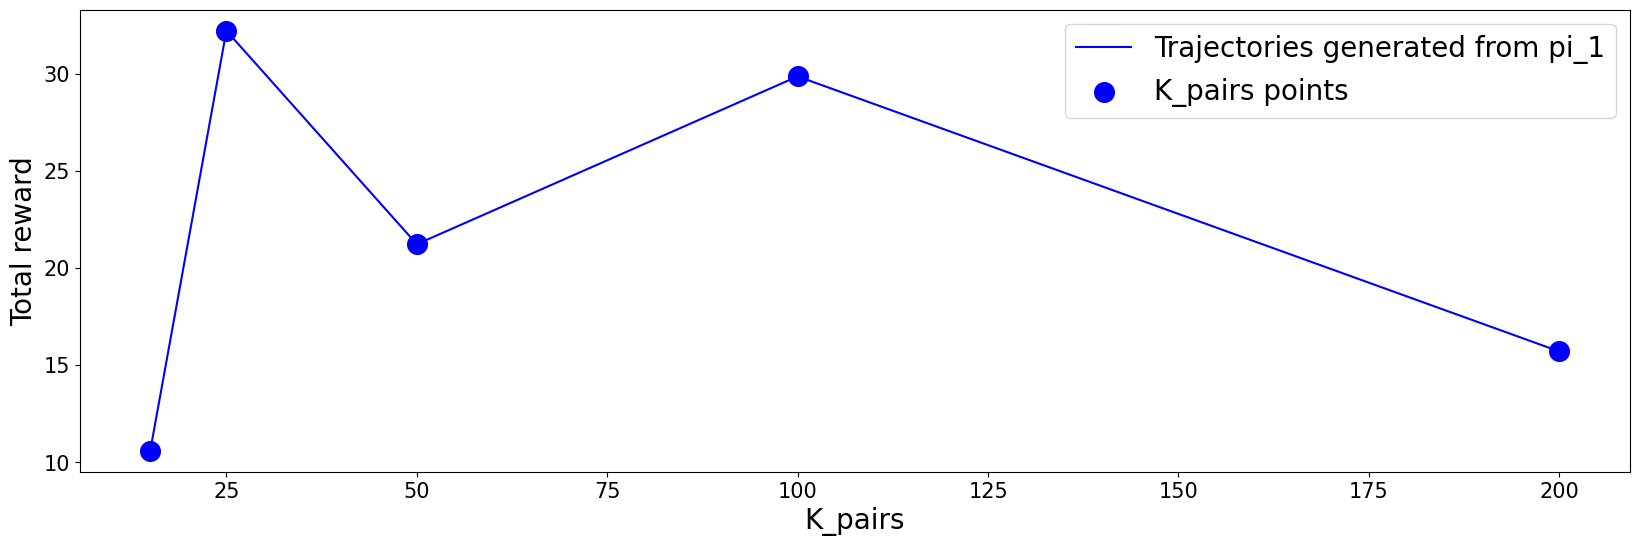

In [42]:
# Plot the results
K_pairs = [15, 25, 50, 100, 200]  # Make sure this matches your experiment

fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(111)

# Plot the line
ax.plot(K_pairs, tot_reward_per_k_pairs, color='blue', label='Trajectories generated from pi_1')

# Add big scatter points
ax.scatter(K_pairs, tot_reward_per_k_pairs, color='blue', s=200, zorder=5, label='K_pairs points')

# Set the labels with a larger font size
ax.set_ylabel('Total reward', fontsize=20)
ax.set_xlabel('K_pairs', fontsize=20)

# Set the tick labels to a larger font size
ax.tick_params(axis='both', which='major', labelsize=15)

# Add a legend with a specified font size
ax.legend(fontsize=20)

# Show the plot
plt.show()


### MountainCar

In [50]:
class PolicyMountainCar(nn.Module):
    def __init__(self, state_size=2, action_size=3, hidden_size=32):
        super(PolicyMountainCar, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = self.fc2(x)
        return F.softmax(x, dim=1) # we just consider 1 dimensional probability of action

    def get_prob(self, state, action):
        """
        Returns action probabilities and state-value estimate
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        return probs[0, action]

In [48]:
# Open dataset for MountainCar (40 pairs trajectories)
pref_dataset_K_pairs_Mountain = []
# 15 paired trajectory
with open('paired_15_traj_pi1_pi2.csv', mode='r') as file:
    reader = csv.reader(file)
    rows = list(reader)

pref_dataset = []
for row in rows[1:]:
    pref_dataset.append([row[2], row[3], row[4]])

pref_dataset_K_pairs_Mountain.append(pref_dataset)

# 25 paired trajectory
with open('paired_25_traj_pi1_pi2.csv', mode='r') as file:
    reader = csv.reader(file)
    rows = list(reader)

pref_dataset = []
for row in rows[1:]:
    pref_dataset.append([row[2], row[3], row[4]])

pref_dataset_K_pairs_Mountain.append(pref_dataset)

# 50 paired trajectory
with open('paired_50_traj_pi1_pi2.csv', mode='r') as file:
    reader = csv.reader(file)
    rows = list(reader)

pref_dataset = []
for row in rows[1:]:
    pref_dataset.append([row[2], row[3], row[4]])

pref_dataset_K_pairs_Mountain.append(pref_dataset)

# 50 paired trajectory
with open('paired_100_traj_pi1_pi2.csv', mode='r') as file:
    reader = csv.reader(file)
    rows = list(reader)

pref_dataset = []
for row in rows[1:]:
    pref_dataset.append([row[2], row[3], row[4]])

pref_dataset_K_pairs_Mountain.append(pref_dataset)

# 50 paired trajectory
with open('paired_200_traj_pi1_pi2.csv', mode='r') as file:
    reader = csv.reader(file)
    rows = list(reader)

pref_dataset = []
for row in rows[1:]:
    pref_dataset.append([row[2], row[3], row[4]])

pref_dataset_K_pairs_Mountain.append(pref_dataset)

In [51]:
# Generate preference dataset
rewards_per_seed = []
for seed in SEEDS:
    for k in range(len(pref_dataset_K_pairs_Mountain)):
        rewards_K_pairs = []
        #for k in K_pairs:
        policy = PolicyMountainCar().to(device)
        policy.eval()
        optimizer = optim.Adam(policy.parameters(), lr=0.1)  # Reduced learning rate for stability
        beta = 1.0


        # Convert the dataset to the correct format for dpo_loss
        def convert_pref_dataset(pref_dataset):
            converted = []
            for state_str, a_plus_str, a_minus_str in pref_dataset:
                state = np.array(eval(state_str), dtype=np.float32)
                a_plus = int(a_plus_str)
                a_minus = int(a_minus_str)
                converted.append((state, a_plus, a_minus))
            return converted
        
        for epoch in range(60):  # Train for 60 epochs
            converted_dataset = convert_pref_dataset(pref_dataset_K_pairs_Mountain[k])
            loss = dpo_loss(converted_dataset, policy, beta)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            print(f"Epoch {epoch + 1}, Loss: {loss.item()}")
        
            env = gym.make(ENV_NAME[1])
            env.reset(seed=seed)
            trajectories_rewards_pi1, trajectories_states_pi1, trajectories_actions_pi1 = generate_trajectories(policy, k, env=env, max_t=1000, seed = seed, dim_state=4)
            env.close()
            
            avg_pi1 = np.mean(trajectories_rewards_pi1)
            rewards_K_pairs.append(avg_pi1)

        rewards_per_seed.append(rewards_K_pairs)

# results
tot_reward_per_k_pairs_Mountain = np.mean(rewards_per_seed, axis=0)

Epoch 1, Loss: 0.6973984241485596


c:\Users\mikae\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mikae\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch 2, Loss: 0.667732834815979
Epoch 3, Loss: 0.6186701655387878
Epoch 4, Loss: 0.6352837681770325
Epoch 5, Loss: 0.6259628534317017
Epoch 6, Loss: 0.608869194984436
Epoch 7, Loss: 0.6092970371246338
Epoch 8, Loss: 0.6079325079917908
Epoch 9, Loss: 0.5968139171600342
Epoch 10, Loss: 0.5897424817085266
Epoch 11, Loss: 0.5926900506019592
Epoch 12, Loss: 0.5951167941093445
Epoch 13, Loss: 0.5892325043678284
Epoch 14, Loss: 0.5814295411109924
Epoch 15, Loss: 0.5803453922271729
Epoch 16, Loss: 0.580635130405426
Epoch 17, Loss: 0.5740819573402405
Epoch 18, Loss: 0.5682636499404907
Epoch 19, Loss: 0.5681864023208618
Epoch 20, Loss: 0.5636441707611084
Epoch 21, Loss: 0.5547364354133606
Epoch 22, Loss: 0.5523880124092102
Epoch 23, Loss: 0.5484111905097961
Epoch 24, Loss: 0.5395804643630981
Epoch 25, Loss: 0.5372125506401062
Epoch 26, Loss: 0.530127227306366
Epoch 27, Loss: 0.5229594111442566
Epoch 28, Loss: 0.5198960304260254
Epoch 29, Loss: 0.5110899806022644
Epoch 30, Loss: 0.50905770063400

ValueError: could not broadcast input array from shape (2,) into shape (4,)

In [ ]:
# Plot the results
K_pairs = [15, 25, 50, 100, 200]  # Make sure this matches your experiment

fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(111)

# Plot the line
ax.plot(K_pairs, tot_reward_per_k_pairs_Mountain, color='blue', label='Trajectories generated from policy')

# Add big scatter points
ax.scatter(K_pairs, tot_reward_per_k_pairs_Mountain, color='blue', s=200, zorder=5, label='K_pairs points')

# Set the labels with a larger font size
ax.set_ylabel('Total reward', fontsize=20)
ax.set_xlabel('K_pairs', fontsize=20)

# Set the tick labels to a larger font size
ax.tick_params(axis='both', which='major', labelsize=15)

# Add a legend with a specified font size
ax.legend(fontsize=20)

# Show the plot
plt.show()